In [8]:
import os
import torch
import argparse
import torchvision.utils as vutils
from libs.Loader import Dataset
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4  # Use encoder3, decoder3 if using r31
from libs.utils import print_options
import torch.backends.cudnn as cudnn
import numpy as np
from PIL import Image

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1
        self.matrixPath = 'models/r41.pth'

opt = Options()




/tmp/ipykernel_4888/2431027631.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matrix = torch.load(matrix_path)


Matrix: 01_02_1_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


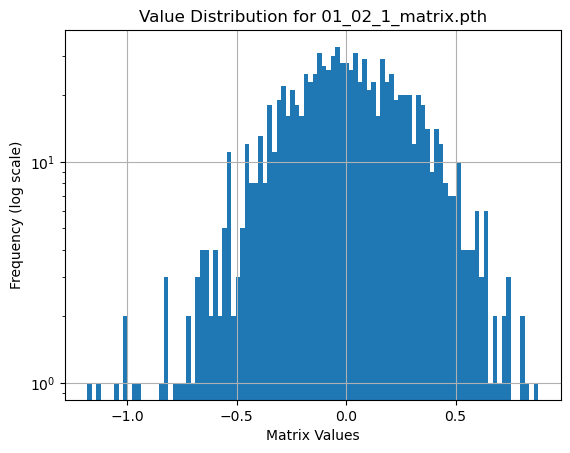

Matrix: 15_02_15_matrix.pth
  - Sparsity Ratio: 0.0059
  - Zero or Near-Zero Elements: 6/1024


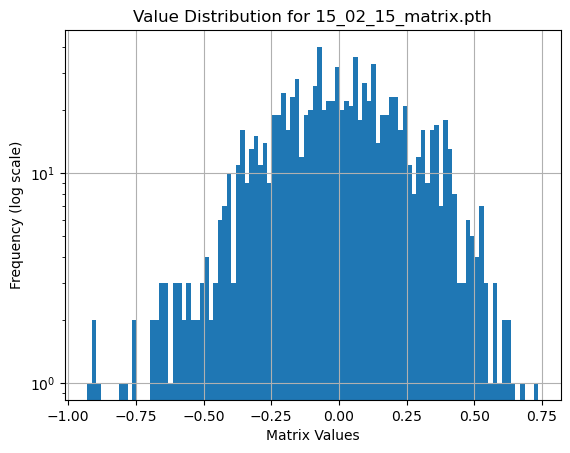

Matrix: 10_02_10_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


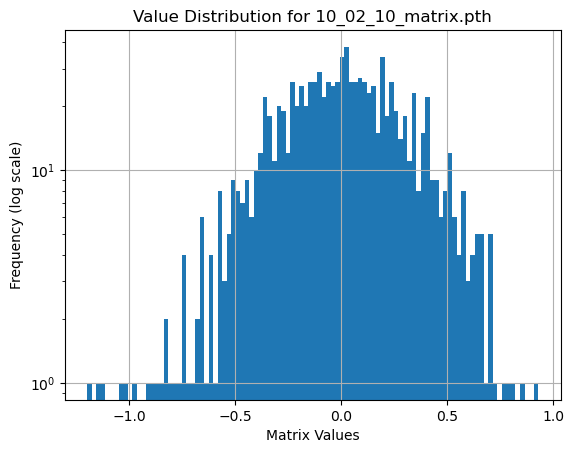

Matrix: 04_02_4_matrix.pth
  - Sparsity Ratio: 0.0039
  - Zero or Near-Zero Elements: 4/1024


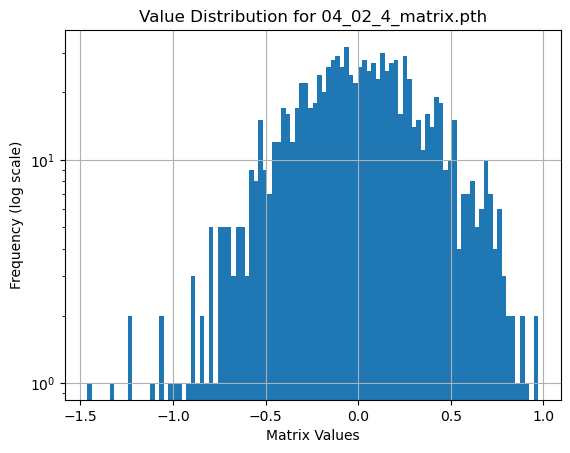

Matrix: 05_02_5_matrix.pth
  - Sparsity Ratio: 0.0000
  - Zero or Near-Zero Elements: 0/1024


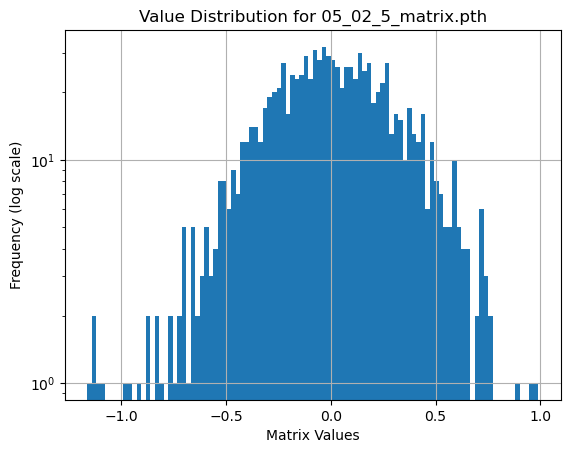

Matrix: 11_02_11_matrix.pth
  - Sparsity Ratio: 0.0010
  - Zero or Near-Zero Elements: 1/1024


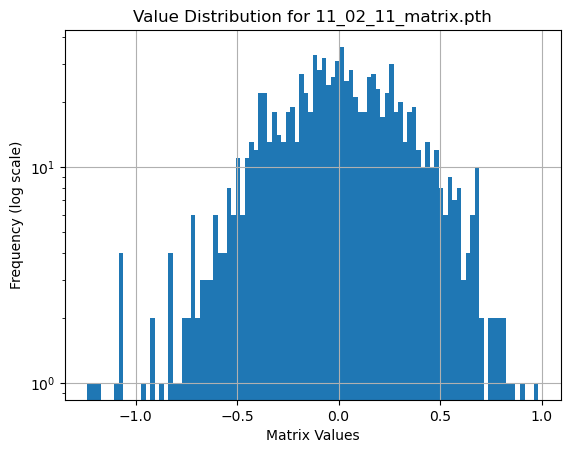

Matrix: 14_02_14_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


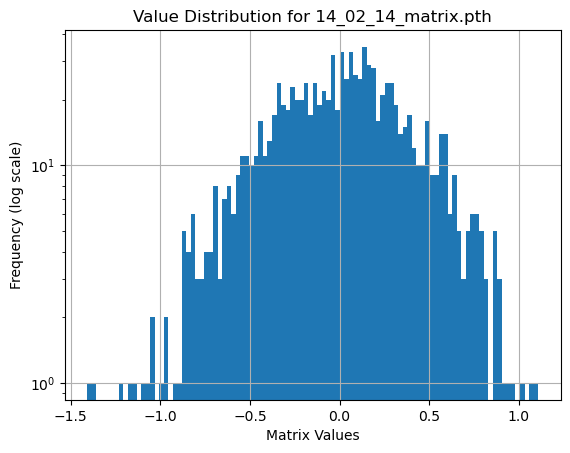

Matrix: 12_02_12_matrix.pth
  - Sparsity Ratio: 0.0029
  - Zero or Near-Zero Elements: 3/1024


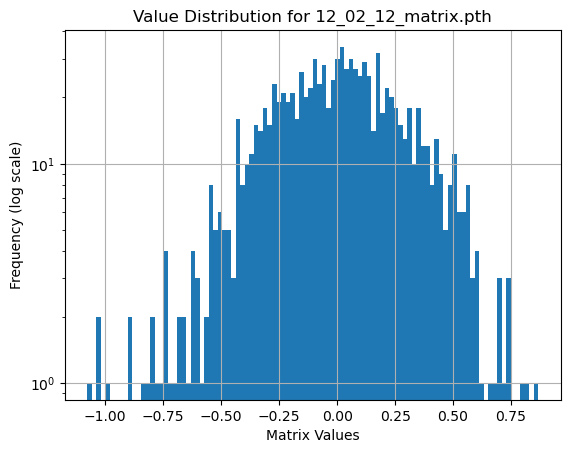

Matrix: 07_02_7_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


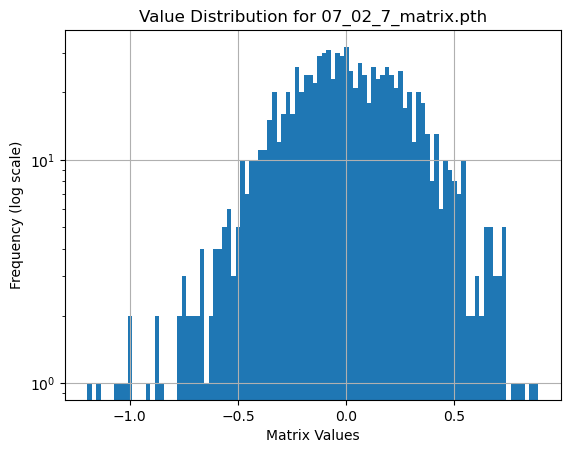

Matrix: 13_02_13_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


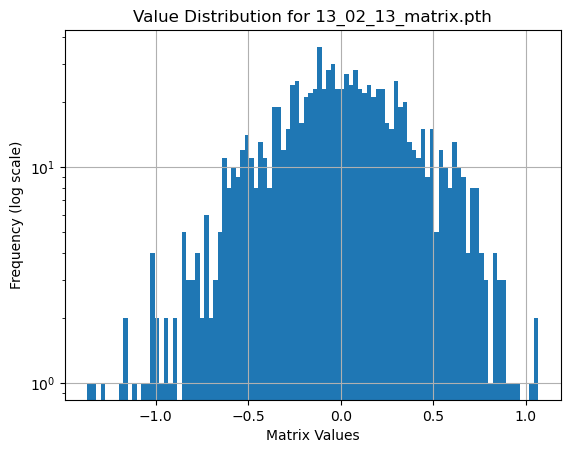

Matrix: 08_02_8_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


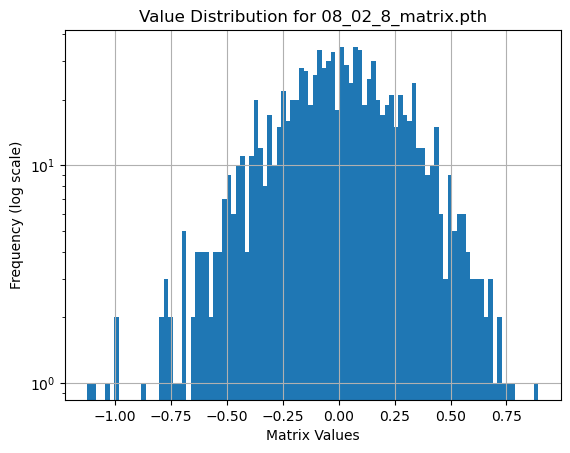

Matrix: 03_02_3_matrix.pth
  - Sparsity Ratio: 0.0029
  - Zero or Near-Zero Elements: 3/1024


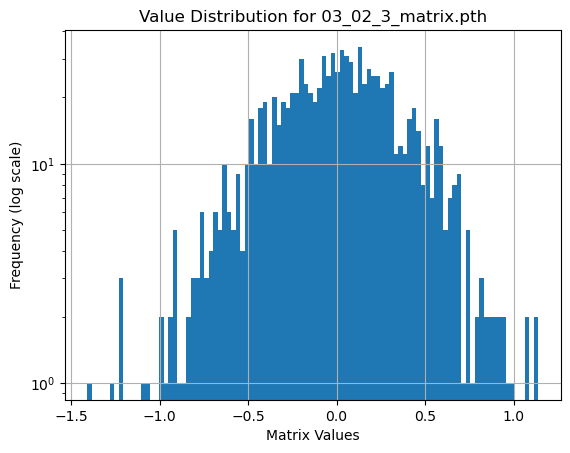

Matrix: 09_02_9_matrix.pth
  - Sparsity Ratio: 0.0029
  - Zero or Near-Zero Elements: 3/1024


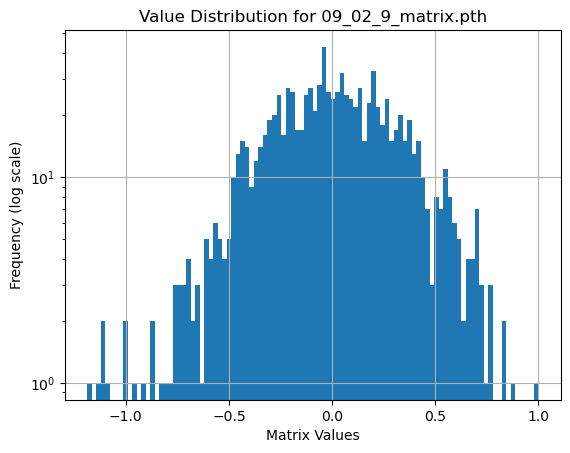

Matrix: 06_02_6_matrix.pth
  - Sparsity Ratio: 0.0000
  - Zero or Near-Zero Elements: 0/1024


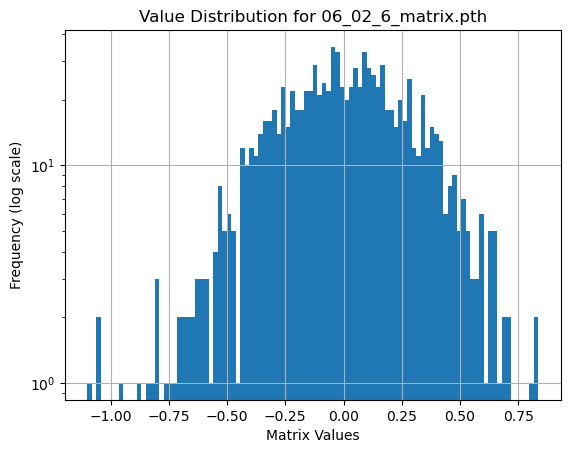

Matrix: 16_02_16_matrix.pth
  - Sparsity Ratio: 0.0010
  - Zero or Near-Zero Elements: 1/1024


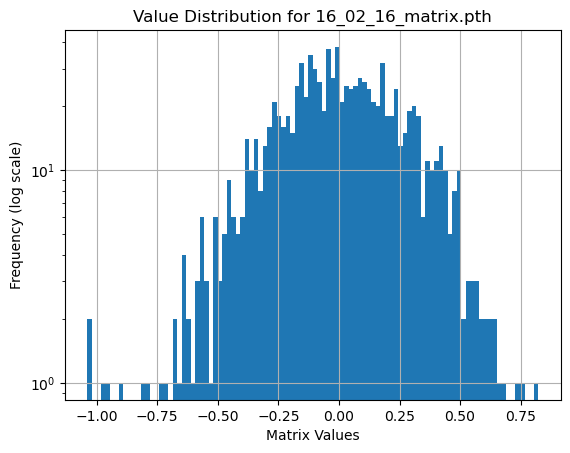

Matrix: 02_02_2_matrix.pth
  - Sparsity Ratio: 0.0020
  - Zero or Near-Zero Elements: 2/1024


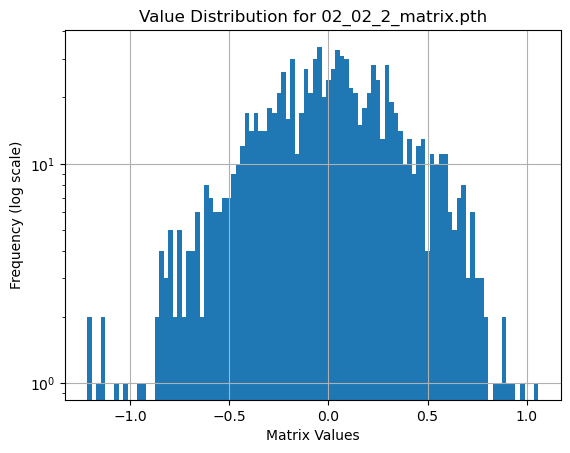

In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def check_matrix_sparsity(matrix_dir, threshold=1e-6):
    """
    Calculates the sparsity of transformation matrices by checking the proportion and count of elements
    close to zero, below a specified threshold.
    
    Args:
        matrix_dir (str): Directory containing the saved transformation matrices in .pth format.
        threshold (float): Values below this threshold are considered zero (for sparsity calculation).
        
    Returns:
        sparsity_results (dict): Dictionary with filenames as keys and details (sparsity ratio, 
                                 count of near-zero elements, total elements) as values.
    """
    sparsity_results = {}
    matrix_files = [f for f in os.listdir(matrix_dir) if f.endswith('.pth')]

    for matrix_file in matrix_files:
        matrix_path = os.path.join(matrix_dir, matrix_file)
        matrix = torch.load(matrix_path)
        
        # Flatten the matrix and convert to numpy for easy processing
        matrix_np = matrix.cpu().numpy().flatten()
        
        # Calculate sparsity: number and proportion of near-zero elements
        zero_elements = np.sum(np.abs(matrix_np) < threshold)
        total_elements = matrix_np.size
        sparsity_ratio = zero_elements / total_elements
        
        # Store results with details about count and proportion of zero elements
        sparsity_results[matrix_file] = {
            "sparsity_ratio": sparsity_ratio,
            "zero_count": zero_elements,
            "total_elements": total_elements
        }
        
        print(f"Matrix: {matrix_file}")
        print(f"  - Sparsity Ratio: {sparsity_ratio:.4f}")
        print(f"  - Zero or Near-Zero Elements: {zero_elements}/{total_elements}")

        # Optional: Plot histogram of matrix values for visual inspection
        plt.figure()
        plt.hist(matrix_np, bins=100, log=True)
        plt.title(f'Value Distribution for {matrix_file}')
        plt.xlabel('Matrix Values')
        plt.ylabel('Frequency (log scale)')
        plt.grid(True)
        plt.show()

    return sparsity_results

# Example usage:
matrix_dir = 'Matrices/02'  # Replace with the path to your matrix directory
sparsity_results = check_matrix_sparsity(matrix_dir, threshold=1e-3)



In [15]:
import torch
import torch.nn as nn

class styleLoss(nn.Module):
    def forward(self, input, target):
        ib, ic, ih, iw = input.size()
        iF = input.view(ib, ic, -1)
        iMean = torch.mean(iF, dim=2)
        iCov = GramMatrix()(input)

        tb, tc, th, tw = target.size()
        tF = target.view(tb, tc, -1)
        tMean = torch.mean(tF, dim=2)
        tCov = GramMatrix()(target)

        # Calculate style loss with mean and covariance (Gram matrix) comparison
        mean_loss = nn.MSELoss(reduction='sum')(iMean, tMean)
        cov_loss = nn.MSELoss(reduction='sum')(iCov, tCov)
        return (mean_loss + cov_loss) / tb

class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h * w)  # reshape to b x c x (h * w)
        G = torch.bmm(f, f.transpose(1, 2))  # batch matrix multiplication
        return G.div(c * h * w)

class LossCriterion(nn.Module):
    def __init__(self, style_layers, content_layers, style_weight, content_weight):
        super(LossCriterion, self).__init__()

        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight

        # Instantiate separate loss instances for each layer
        self.styleLosses = nn.ModuleList([styleLoss() for _ in style_layers])
        self.contentLosses = nn.ModuleList([nn.MSELoss() for _ in content_layers])

    def forward(self, tF, sF, cF):
        # Compute content loss
        totalContentLoss = 0
        for i, layer in enumerate(self.content_layers):
            cf_i = cF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.contentLosses[i]
            totalContentLoss += loss_i(tf_i, cf_i)
        totalContentLoss *= self.content_weight

        # Compute style loss
        totalStyleLoss = 0
        for i, layer in enumerate(self.style_layers):
            sf_i = sF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.styleLosses[i]
            totalStyleLoss += loss_i(tf_i, sf_i)
        totalStyleLoss *= self.style_weight

        # Combined loss
        loss = totalStyleLoss + totalContentLoss
        return loss, totalStyleLoss, totalContentLoss


In [11]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.Matrix import MulLayer
import torch.backends.cudnn as cudnn
from libs.utils import print_options
from libs.models import encoder3, encoder4, decoder3, decoder4

class Options:
    def __init__(self):
        # Paths and model settings
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.batchSize = 1
        self.vgg_dir_r31 = 'models/vgg_r31.pth'
        self.decoder_dir_r31 = 'models/dec_r31.pth'
        self.matrixPath_r31 = 'models/r31.pth'
        self.vgg_dir_r41 = 'models/vgg_r41.pth'
        self.decoder_dir_r41 = 'models/dec_r41.pth'
        self.matrixPath_r41 = 'models/r41.pth'
        self.layer = 'r41'  # Can be 'r31' or 'r41'
        self.outf = "Artistic/blended/"
        self.matrixOutf = "Matrices/"
        # Check for GPU availability
        self.cuda = torch.cuda.is_available()

# Initialize options
opt = Options()
print_options(opt)

# Set up directories and GPU benchmark
os.makedirs(opt.outf, exist_ok=True)
os.makedirs(opt.matrixOutf, exist_ok=True)
cudnn.benchmark = True

# Alpha values for blending between r31 and r41 features
alpha_values = [0, 0.25, 0.5, 0.75, 1.0]

# Get all content and style image files
content_files = sorted([f for f in os.listdir(opt.contentPath) if f.endswith(('.png', '.jpg', '.jpeg'))])
style_files = sorted([f for f in os.listdir(opt.stylePath) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Load datasets
content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

# Load models for r31 and r41 layers
vgg3, dec3, matrix3 = encoder3(), decoder3(), MulLayer('r31')
vgg4, dec4, matrix4 = encoder4(), decoder4(), MulLayer('r41')
vgg3.load_state_dict(torch.load(opt.vgg_dir_r31))
dec3.load_state_dict(torch.load(opt.decoder_dir_r31))
matrix3.load_state_dict(torch.load(opt.matrixPath_r31))
vgg4.load_state_dict(torch.load(opt.vgg_dir_r41))
dec4.load_state_dict(torch.load(opt.decoder_dir_r41))
matrix4.load_state_dict(torch.load(opt.matrixPath_r41))

# Channel adjuster to match the channels from r31 to r41 (256 -> 512 channels)
channel_adjuster = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)
if opt.cuda:
    channel_adjuster.cuda()

# Move models to GPU if available
if opt.cuda:
    vgg3.cuda(), dec3.cuda(), matrix3.cuda()
    vgg4.cuda(), dec4.cuda(), matrix4.cuda()

# Prepare tensors for content and style images
contentV = torch.Tensor(opt.batchSize, 3, opt.fineSize, opt.fineSize)
styleV = torch.Tensor(opt.batchSize, 3, opt.fineSize, opt.fineSize)
if opt.cuda:
    contentV, styleV = contentV.cuda(), styleV.cuda()

# Processing each style and content image pair
for styleIdx, styleName in enumerate(style_files):
    style_image_path = os.path.join(opt.stylePath, styleName)
    style_image = style_dataset[styleIdx][0].unsqueeze(0)
    styleV.copy_(style_image)

    style_base = os.path.splitext(styleName)[0]
    style_output_dir = os.path.join(opt.outf, style_base)
    os.makedirs(style_output_dir, exist_ok=True)

    for contentIdx, contentName in enumerate(content_files):
        content_image_path = os.path.join(opt.contentPath, contentName)
        content_image = content_dataset[contentIdx][0].unsqueeze(0)
        contentV.copy_(content_image)

        content_base = os.path.splitext(contentName)[0]
        generated_images = []

        # Loop over alpha values for blending
        for alpha in alpha_values:
            with torch.no_grad():
                # Extract r31 features
                sF3, cF3 = vgg3(styleV), vgg3(contentV)
                feature_r31, _ = matrix3(cF3, sF3)

                # Extract r41 features
                sF4, cF4 = vgg4(styleV), vgg4(contentV)
                feature_r41, _ = matrix4(cF4['r41'], sF4['r41'])

                # Resize and adjust channels for r31 features to match r41 dimensions
                feature_r31_resized = torch.nn.functional.interpolate(
                    feature_r31, size=feature_r41.shape[2:], mode='bilinear', align_corners=False
                )
                feature_r31_adjusted = channel_adjuster(feature_r31_resized)

                # Blend r31 and r41 features based on alpha
                blended_feature = alpha * feature_r41 + (1 - alpha) * feature_r31_adjusted

                # Decode blended feature to image
                transfer = dec4(blended_feature).clamp(0, 1)
                generated_images.append(transfer.cpu().squeeze())

        # Plot and save comparison
        fig, axs = plt.subplots(1, len(alpha_values), figsize=(15, 5))
        for i, alpha in enumerate(alpha_values):
            axs[i].imshow(generated_images[i].permute(1, 2, 0).numpy())
            axs[i].set_title(f'Alpha: {alpha}')
            axs[i].axis('off')

        torch.cuda.empty_cache()

        # Save plot with style and content image names
        plot_path = f"{style_output_dir}/{content_base}_vs_{style_base}_comparison.png"
        plt.savefig(plot_path)
        plt.close(fig)
        print(f'Comparison plot saved at {plot_path}')


----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
          decoder_dir_r31: models/dec_r31.pth            
          decoder_dir_r41: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixOutf: Matrices/                     
           matrixPath_r31: models/r31.pth                
           matrixPath_r41: models/r41.pth                
                     outf: Artistic/blended/             
                stylePath: data/style/                   
              vgg_dir_r31: models/vgg_r31.pth            
              vgg_dir_r41: models/vgg_r41.pth            
----------------- End -------------------


/tmp/ipykernel_4888/1471642064.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg3.load_state_dict(torch.load(opt.vgg_dir_r31))
/tmp/ipykernel_4888/1471642064.py:55: F

Comparison plot saved at Artistic/blended/01/01_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/02_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/03_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/04_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/05_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/06_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/07_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/08_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/09_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/10_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/11_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/12_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/13_vs_01_comparison.png
Comparison plot saved at Artistic/blended/01/14_vs_01_comparison.png
Comparison plot saved at Artistic/

In [12]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.Matrix import MulLayer
import torch.backends.cudnn as cudnn
from libs.utils import print_options
from libs.models import encoder3, encoder4, decoder3, decoder4

class Options:
    def __init__(self):
        # Paths and model settings
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.batchSize = 1
        self.vgg_dir_r31 = 'models/vgg_r31.pth'
        self.decoder_dir_r31 = 'models/dec_r31.pth'
        self.matrixPath_r31 = 'models/r31.pth'
        self.vgg_dir_r41 = 'models/vgg_r41.pth'
        self.decoder_dir_r41 = 'models/dec_r41.pth'
        self.matrixPath_r41 = 'models/r41.pth'
        self.layer = 'r41'  # Can be 'r31' or 'r41'
        self.outf = "Artistic/blended1/"
        self.matrixOutf = "Matrices/"
        # Check for GPU availability
        self.cuda = torch.cuda.is_available()

# Initialize options
opt = Options()
print_options(opt)

# Set up directories and GPU benchmark
os.makedirs(opt.outf, exist_ok=True)
os.makedirs(opt.matrixOutf, exist_ok=True)
cudnn.benchmark = True

# Alpha values for blending between r31 and r41 features
alpha_values = [0, 0.25, 0.5, 0.75, 1.0]

# Get all content and style image files
content_files = sorted([f for f in os.listdir(opt.contentPath) if f.endswith(('.png', '.jpg', '.jpeg'))])
style_files = sorted([f for f in os.listdir(opt.stylePath) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Load datasets
content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

# Load models for r31 and r41 layers
vgg3, dec3, matrix3 = encoder3(), decoder3(), MulLayer('r31')
vgg4, dec4, matrix4 = encoder4(), decoder4(), MulLayer('r41')
vgg3.load_state_dict(torch.load(opt.vgg_dir_r31))
dec3.load_state_dict(torch.load(opt.decoder_dir_r31))
matrix3.load_state_dict(torch.load(opt.matrixPath_r31))
vgg4.load_state_dict(torch.load(opt.vgg_dir_r41))
dec4.load_state_dict(torch.load(opt.decoder_dir_r41))
matrix4.load_state_dict(torch.load(opt.matrixPath_r41))

# Channel adjuster to reduce channels from r41 features (512 -> 256 channels)
channel_reducer = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
if opt.cuda:
    channel_reducer.cuda()

# Move models to GPU if available
if opt.cuda:
    vgg3.cuda(), dec3.cuda(), matrix3.cuda()
    vgg4.cuda(), dec4.cuda(), matrix4.cuda()

# Prepare tensors for content and style images
contentV = torch.Tensor(opt.batchSize, 3, opt.fineSize, opt.fineSize)
styleV = torch.Tensor(opt.batchSize, 3, opt.fineSize, opt.fineSize)
if opt.cuda:
    contentV, styleV = contentV.cuda(), styleV.cuda()

# Processing each style and content image pair
for styleIdx, styleName in enumerate(style_files):
    style_image_path = os.path.join(opt.stylePath, styleName)
    style_image = style_dataset[styleIdx][0].unsqueeze(0)
    styleV.copy_(style_image)

    style_base = os.path.splitext(styleName)[0]
    style_output_dir = os.path.join(opt.outf, style_base)
    os.makedirs(style_output_dir, exist_ok=True)

    for contentIdx, contentName in enumerate(content_files):
        content_image_path = os.path.join(opt.contentPath, contentName)
        content_image = content_dataset[contentIdx][0].unsqueeze(0)
        contentV.copy_(content_image)

        content_base = os.path.splitext(contentName)[0]
        generated_images = []

        # Loop over alpha values for blending
        for alpha in alpha_values:
            with torch.no_grad():
                # Extract r31 features
                sF3, cF3 = vgg3(styleV), vgg3(contentV)
                feature_r31, _ = matrix3(cF3, sF3)

                # Extract r41 features
                sF4, cF4 = vgg4(styleV), vgg4(contentV)
                feature_r41, _ = matrix4(cF4['r41'], sF4['r41'])

                # Downsample channels of r41 features to 256 channels
                feature_r41_reduced = channel_reducer(feature_r41)

                # Resize feature_r41_reduced to match feature_r31 spatial dimensions
                feature_r41_resized = torch.nn.functional.interpolate(
                    feature_r41_reduced, size=feature_r31.shape[2:], mode='bilinear', align_corners=False
                )

                # Blend r31 and r41 features based on alpha
                blended_feature = alpha * feature_r41_resized + (1 - alpha) * feature_r31

                # Decode blended feature to image
                transfer = dec3(blended_feature).clamp(0, 1)
                generated_images.append(transfer.cpu().squeeze())

        # Plot and save comparison
        fig, axs = plt.subplots(1, len(alpha_values), figsize=(15, 5))
        for i, alpha in enumerate(alpha_values):
            axs[i].imshow(generated_images[i].permute(1, 2, 0).numpy())
            axs[i].set_title(f'Alpha: {alpha}')
            axs[i].axis('off')

        # Save plot with style and content image names
        plot_path = f"{style_output_dir}/{content_base}_vs_{style_base}_comparison.png"
        plt.savefig(plot_path)
        plt.close(fig)
        print(f'Comparison plot saved at {plot_path}')


----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
          decoder_dir_r31: models/dec_r31.pth            
          decoder_dir_r41: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixOutf: Matrices/                     
           matrixPath_r31: models/r31.pth                
           matrixPath_r41: models/r41.pth                
                     outf: Artistic/blended1/            
                stylePath: data/style/                   
              vgg_dir_r31: models/vgg_r31.pth            
              vgg_dir_r41: models/vgg_r41.pth            
----------------- End -------------------


/tmp/ipykernel_4888/860725506.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg3.load_state_dict(torch.load(opt.vgg_dir_r31))
/tmp/ipykernel_4888/860725506.py:55: Fut

Comparison plot saved at Artistic/blended1/01/01_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/02_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/03_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/04_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/05_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/06_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/07_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/08_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/09_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/10_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/11_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/12_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/13_vs_01_comparison.png
Comparison plot saved at Artistic/blended1/01/14_vs_01_comparison.png
Comparison plot save